In [ ]:
# !pip install optuna

In [ ]:
# pip install ydata-profiling

In [4]:
# import packages

import pandas as pd
import datetime
import numpy as np
import shap
import time
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.inspection import partial_dependence

from contextlib import contextmanager


from ydata_profiling import ProfileReport
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

In [5]:


# Read train and test data
df_sales_train = pd.read_csv('/content/train.csv')
df_sales_test = pd.read_csv('/content/test.csv')

df_sales_train['split'] = 'train'
df_sales_test['split'] = 'test'
df_sales_test['Item_Outlet_Sales'] = 0


df_all=pd.concat([df_sales_train,df_sales_test])
display(df_all.tail())
# df_sales_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split
5676,FDB58,10.5,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,0.0,test
5677,FDD47,7.6,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,0.0,test
5678,NCO17,10.0,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1,0.0,test
5679,FDJ26,15.3,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1,0.0,test
5680,FDU37,9.5,Regular,0.104720,Canned,79.7960,OUT045,2002,NaN,Tier 2,Supermarket Type1,0.0,test


#EDA

In [ ]:
# EDA

profile = ProfileReport(df_sales_train)
profile.to_file("bigmart_profile.html")

# Data Cleaning  and Feature Engineering


In [6]:


# Item_Fat Content standardization
df_all["Item_Fat_Content"] = df_all["Item_Fat_Content"].str.strip().str.lower().str.replace(' ', '')

df_all["Item_Fat_Content"] = df_all["Item_Fat_Content"].replace({
    "lf": "low fat",
    "reg": "regular"
})

In [7]:
# Imputing Iem weight with mean weight

mean_item_weight = df_all.groupby('Item_Identifier')['Item_Weight'].mean()


df_all['Item_Weight'] = df_all['Item_Weight'].fillna(df_all['Item_Identifier'].map(mean_item_weight))

print(f"Remaining NaN values in 'Item_Weight' after imputation: {df_all['Item_Weight'].isnull().sum()}")
display(df_all.head())

Remaining NaN values in 'Item_Weight' after imputation: 0


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [8]:
df_sales_train['Item_Weight'].isnull().sum()

np.int64(1463)

In [9]:
# Group statistics at outlet level

sales_and_outlet_stats = df_all.groupby(['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type','Outlet_Identifier','Outlet_Establishment_Year'], dropna=False).agg(
    total_item_sales=('Item_Outlet_Sales', 'sum'),
    distinct_outlets=('Outlet_Identifier', 'nunique'),
    distinct_item=('Item_Identifier', 'nunique'),
).reset_index()
display(sales_and_outlet_stats)

,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier,Outlet_Establishment_Year,total_item_sales,distinct_outlets,distinct_item
0,High,Tier 3,Supermarket Type1,OUT013,1987,2.142664e+06,1,1553
1,Medium,Tier 1,Supermarket Type1,OUT049,1999,2.183970e+06,1,1550
2,Medium,Tier 3,Supermarket Type2,OUT018,2009,1.851823e+06,1,1546
3,Medium,Tier 3,Supermarket Type3,OUT027,1985,3.453926e+06,1,1559
4,Small,Tier 1,Grocery Store,OUT019,1985,1.796941e+05,1,880
5,Small,Tier 1,Supermarket Type1,OUT046,1997,2.118395e+06,1,1550
6,Small,Tier 2,Supermarket Type1,OUT035,2004,2.268123e+06,1,1550
7,NaN,Tier 2,Supermarket Type1,OUT017,2007,2.167465e+06,1,1543
8,NaN,Tier 2,Supermarket Type1,OUT045,2002,2.036725e+06,1,1548
9,NaN,Tier 3,Grocery Store,OUT010,1998,1.883402e+05,1,925


In [10]:
# imputing outlet size

df_all['Outlet_Size']=df_all['Outlet_Size'].fillna('Small')

In [11]:
# Imputing item visibility with mean visibility per item

mean_visibility_by_item_type = df_all[df_all['Item_Visibility'] != 0].groupby('Item_Type')['Item_Visibility'].mean()

df_all['Item_Visibility_masked'] = df_all['Item_Visibility'].copy()

zero_visibility_mask = df_all['Item_Visibility_masked'] == 0

df_all.loc[zero_visibility_mask, 'Item_Visibility_masked'] = df_all.loc[zero_visibility_mask, 'Item_Type'].map(mean_visibility_by_item_type)

print(f"Number of 0 values in 'Item_Visibility_masked' after imputation: {(df_all['Item_Visibility_masked'] == 0).sum()}")
display(df_all.head())

Number of 0 values in 'Item_Visibility_masked' after imputation: 0


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186


In [12]:
# calculating outlet_age variable

df_all['Current_Year'] = datetime.datetime.now().year
df_all['Outlet_Age'] = df_all['Current_Year'] - df_all['Outlet_Establishment_Year']

In [13]:
# calculating outlet average sales

train_outlet_avg_sales = df_all[df_all['split'] == 'train'].groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean()
df_all['Outlet_Average_Sales'] = df_all['Outlet_Identifier'].map(train_outlet_avg_sales)
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047,2026,27,2348.354635
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278,2026,17,1995.498739
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760,2026,27,2348.354635
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305,2026,28,339.351662
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186,2026,39,2298.995256


In [14]:
(df_all['Outlet_Average_Sales'] == 0).sum()

np.int64(0)

In [15]:
# extracting item category

df_all['item_category'] = df_all['Item_Identifier'].str.slice(0, 2)
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047,2026,27,2348.354635,FD
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278,2026,17,1995.498739,DR
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760,2026,27,2348.354635,FD
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305,2026,28,339.351662,FD
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186,2026,39,2298.995256,NC


In [16]:
# calculating item count per outlet

outlet_item_count = df_all.groupby('Outlet_Identifier')['Item_Identifier'].nunique().reset_index()
outlet_item_count.rename(columns={'Item_Identifier': 'Outlet_Item_Count'}, inplace=True)
df_all = pd.merge(df_all, outlet_item_count, on='Outlet_Identifier', how='left')
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category,Outlet_Item_Count
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047,2026,27,2348.354635,FD,1550
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278,2026,17,1995.498739,DR,1546
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760,2026,27,2348.354635,FD,1550
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305,2026,28,339.351662,FD,925
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186,2026,39,2298.995256,NC,1553


In [17]:

# calculating average sales per item category per outlet

item_cat_avg_sales_per_outlet = df_all[df_all['split'] == 'train'].groupby(['Outlet_Identifier', 'item_category'])['Item_Outlet_Sales'].mean().reset_index()
item_cat_avg_sales_per_outlet = item_cat_avg_sales_per_outlet.rename(columns={'Item_Outlet_Sales': 'Item_cat_Avg_Sales_Per_Outlet'})
df_all = pd.merge(df_all, item_cat_avg_sales_per_outlet, on=['Outlet_Identifier', 'item_category'], how='left')
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047,2026,27,2348.354635,FD,1550,2337.653479
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278,2026,17,1995.498739,DR,1546,1907.604188
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760,2026,27,2348.354635,FD,1550,2337.653479
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305,2026,28,339.351662,FD,925,334.778691
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186,2026,39,2298.995256,NC,1553,2235.667627


In [18]:
# calculating visibility ratio

df_all['Item_Visibility_Mean'] = df_all.groupby('Item_Identifier')['Item_Visibility'].transform('mean')
df_all['Visibility_Ratio'] = df_all['Item_Visibility'] / df_all['Item_Visibility_Mean']
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Visibility_Mean,Visibility_Ratio
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,train,0.016047,2026,27,2348.354635,FD,1550,2337.653479,0.017235,0.931078
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,train,0.019278,2026,17,1995.498739,DR,1546,1907.604188,0.020653,0.933420
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,train,0.016760,2026,27,2348.354635,FD,1550,2337.653479,0.017457,0.960069
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,train,0.073305,2026,28,339.351662,FD,925,334.778691,0.017834,0.000000
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,train,0.063186,2026,39,2298.995256,NC,1553,2235.667627,0.009780,0.000000


In [19]:
# grouping item type

df_all['Item_Type_cleaned'] = df_all['Item_Type'].str.strip().str.lower().str.replace(' ', '')

def item_type_grouper(item_type):
    if item_type in [
        'fruitsandvegetables', 'snackfoods', 'household', 'frozenfoods',
        'dairy', 'canned', 'bakinggoods', 'healthandhygiene', 'softdrinks', 'meat'
    ]:
        return item_type
    else:
        return 'others'

df_all['item_type_grouped'] = df_all['Item_Type_cleaned'].apply(item_type_grouper)
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Visibility_Mean,Visibility_Ratio,Item_Type_cleaned,item_type_grouped
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,2026,27,2348.354635,FD,1550,2337.653479,0.017235,0.931078,dairy,dairy
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,2026,17,1995.498739,DR,1546,1907.604188,0.020653,0.933420,softdrinks,softdrinks
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,2026,27,2348.354635,FD,1550,2337.653479,0.017457,0.960069,meat,meat
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,2026,28,339.351662,FD,925,334.778691,0.017834,0.000000,fruitsandvegetables,fruitsandvegetables
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,2026,39,2298.995256,NC,1553,2235.667627,0.009780,0.000000,household,household


In [20]:
df_all['Outlet_Type_cleaned'] = df_all['Outlet_Type'].str.strip().str.lower().str.replace(' ', '')

In [21]:
df_all['Outlet_Location_Type_cleaned'] = df_all['Outlet_Location_Type'].str.strip().str.lower().str.replace(' ', '')

In [22]:
# item price bucket created

df_all['item_price_bucket'] = pd.qcut(df_all['Item_MRP'], q=4, labels=['Low', 'Med', 'High', 'Premium'])

item_price_map = {'Low': 1, 'Med': 2, 'High': 3, 'Premium': 4}
df_all['item_price_bucket'] = df_all['item_price_bucket'].map(item_price_map)

display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,item_category,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Visibility_Mean,Visibility_Ratio,Item_Type_cleaned,item_type_grouped,Outlet_Type_cleaned,Outlet_Location_Type_cleaned,item_price_bucket
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,FD,1550,2337.653479,0.017235,0.931078,dairy,dairy,supermarkettype1,tier1,4
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,DR,1546,1907.604188,0.020653,0.933420,softdrinks,softdrinks,supermarkettype2,tier3,1
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,FD,1550,2337.653479,0.017457,0.960069,meat,meat,supermarkettype1,tier1,2
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,FD,925,334.778691,0.017834,0.000000,fruitsandvegetables,fruitsandvegetables,grocerystore,tier3,3
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,NC,1553,2235.667627,0.009780,0.000000,household,household,supermarkettype1,tier3,1


In [23]:

# interaction variable created: MRP X outlet type

outlet_mean = df_all[df_all['split'] == 'train'].groupby('Outlet_Type')['Item_Outlet_Sales'].mean()

df_all["Outlet_Type_TE"] = df_all["Outlet_Type"].map(outlet_mean)

df_all["MRP_x_OutletType"] = df_all["Item_MRP"] * df_all["Outlet_Type_TE"]
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Item_cat_Avg_Sales_Per_Outlet,Item_Visibility_Mean,Visibility_Ratio,Item_Type_cleaned,item_type_grouped,Outlet_Type_cleaned,Outlet_Location_Type_cleaned,item_price_bucket,Outlet_Type_TE,MRP_x_OutletType
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,2337.653479,0.017235,0.931078,dairy,dairy,supermarkettype1,tier1,4,2316.181148,578603.359664
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,1907.604188,0.020653,0.933420,softdrinks,softdrinks,supermarkettype2,tier3,1,1995.498739,96321.127743
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,2337.653479,0.017457,0.960069,meat,meat,supermarkettype1,tier1,2,2316.181148,328012.941833
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,334.778691,0.017834,0.000000,fruitsandvegetables,fruitsandvegetables,grocerystore,tier3,3,339.828500,61881.070792
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,2235.667627,0.009780,0.000000,household,household,supermarkettype1,tier3,1,2316.181148,124752.759291


In [24]:
# Nonlinear price
df_all["MRP_squared"] = df_all["Item_MRP"] ** 2

In [25]:
# other price related features

df_all["MRP_log"] = np.log1p(df_all["Item_MRP"])
df_all["MRP_x_OutletAvg"] = df_all["Item_MRP"] * df_all["Outlet_Average_Sales"]

In [26]:
df_all.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'split', 'Item_Visibility_masked',
       'Current_Year', 'Outlet_Age', 'Outlet_Average_Sales', 'item_category',
       'Outlet_Item_Count', 'Item_cat_Avg_Sales_Per_Outlet',
       'Item_Visibility_Mean', 'Visibility_Ratio', 'Item_Type_cleaned',
       'item_type_grouped', 'Outlet_Type_cleaned',
       'Outlet_Location_Type_cleaned', 'item_price_bucket', 'Outlet_Type_TE',
       'MRP_x_OutletType', 'MRP_squared', 'MRP_log', 'MRP_x_OutletAvg'],
      dtype='object')

# Categorical feature encoding

In [54]:
df_all_filtered = df_all.copy()

# Define ordinal mapping for Outlet_Size
outlet_size_map = {'Small': 0, 'Medium': 1, 'High': 2}
df_all_filtered['Outlet_Size'] = df_all_filtered['Outlet_Size'].map(outlet_size_map)

fat_map = {'lowfat': 0, 'regular': 1}
df_all_filtered['Item_Fat_Content'] = df_all_filtered['Item_Fat_Content'].map(fat_map)

# Select the final set of features for the model, now with ordinally encoded Outlet_Size
df_all_filtered = df_all_filtered[['Item_Identifier', 'Item_Weight', 'Visibility_Ratio',
         'Outlet_Identifier', 'Outlet_Age',
        'Outlet_Type_cleaned','item_category',
       'split',
       'Outlet_Item_Count', 'Item_cat_Avg_Sales_Per_Outlet',
       'Item_Outlet_Sales','Item_MRP','Outlet_Average_Sales']]

      #  'Outlet_Location_Type_cleaned', 'Item_Fat_Content','item_type_grouped', 'Outlet_Size','','MRP_x_OutletType,,'MRP_squared'
      # ,'Item_MRP','MRP_log','Outlet_Average_Sales',

display(df_all_filtered.head())

,Item_Identifier,Item_Weight,Visibility_Ratio,Outlet_Identifier,Outlet_Age,Outlet_Type_cleaned,item_category,split,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Outlet_Sales,Item_MRP,Outlet_Average_Sales
0,FDA15,9.30,0.931078,OUT049,27,supermarkettype1,FD,train,1550,2337.653479,3735.1380,249.8092,2348.354635
1,DRC01,5.92,0.933420,OUT018,17,supermarkettype2,DR,train,1546,1907.604188,443.4228,48.2692,1995.498739
2,FDN15,17.50,0.960069,OUT049,27,supermarkettype1,FD,train,1550,2337.653479,2097.2700,141.6180,2348.354635
3,FDX07,19.20,0.000000,OUT010,28,grocerystore,FD,train,925,334.778691,732.3800,182.0950,339.351662
4,NCD19,8.93,0.000000,OUT013,39,supermarkettype1,NC,train,1553,2235.667627,994.7052,53.8614,2298.995256


In [55]:

# removed cat var

categorical_cols = [  'Outlet_Type_cleaned','item_category']
# , 'Outlet_Location_Type_cleaned','item_type_grouped', 'item_category'
# Apply one-hot encoding
df_all_filtered = pd.get_dummies(df_all_filtered, columns=categorical_cols, dtype=int)
print(f"Shape of DataFrame after one-hot encoding: {df_all_filtered.shape}")
display(df_all_filtered.head())

Shape of DataFrame after one-hot encoding: (14204, 18)


,Item_Identifier,Item_Weight,Visibility_Ratio,Outlet_Identifier,Outlet_Age,split,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Outlet_Sales,Item_MRP,Outlet_Average_Sales,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC
0,FDA15,9.30,0.931078,OUT049,27,train,1550,2337.653479,3735.1380,249.8092,2348.354635,0,1,0,0,0,1,0
1,DRC01,5.92,0.933420,OUT018,17,train,1546,1907.604188,443.4228,48.2692,1995.498739,0,0,1,0,1,0,0
2,FDN15,17.50,0.960069,OUT049,27,train,1550,2337.653479,2097.2700,141.6180,2348.354635,0,1,0,0,0,1,0
3,FDX07,19.20,0.000000,OUT010,28,train,925,334.778691,732.3800,182.0950,339.351662,1,0,0,0,0,1,0
4,NCD19,8.93,0.000000,OUT013,39,train,1553,2235.667627,994.7052,53.8614,2298.995256,0,1,0,0,0,0,1


In [ ]:
# outlet_cols = [col for col in df_all_filtered.columns if "Outlet_Type_" in col]

# for col in outlet_cols:
#     df_all_filtered[f"MRP_x_{col}"] = df_all_filtered["Item_MRP"] * df_all_filtered[col]

#Split into Train and  Test

In [56]:
# Remove the 'test' split data
df_train_only = df_all_filtered[df_all_filtered['split'] == 'train'].copy()

# Drop the 'split' column as it's no longer needed after filtering
df_train_only = df_train_only.drop(columns=['split'])

# Define features (X) and target (y)
# X = df_train_only.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])
X = df_train_only.drop(columns=['Item_Outlet_Sales'])
y = df_train_only['Item_Outlet_Sales']

# print(f"Shape of features (X) before split: {X.shape}")
print(f"Shape of target (y) before split: {y.shape}")

Shape of target (y) before split: (8523,)


In [57]:
X=df_train_only.copy()

In [58]:


# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (6818, 17)
Shape of X_test: (1705, 17)
Shape of y_train: (6818,)
Shape of y_test: (1705,)


In [ ]:
# Define grouping variable
# groups = X_train["Outlet_Identifier"]

In [59]:

outlet_mean = X_train.groupby("Outlet_Identifier")["Item_Outlet_Sales"].mean()

X_train["Outlet_ID_TE"] = X_train["Outlet_Identifier"].map(outlet_mean)
X_test["Outlet_ID_TE"] = X_test["Outlet_Identifier"].map(outlet_mean)

X_train = X_train.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])
X_test = X_test.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])

In [60]:
X_train.columns

Index(['Item_Weight', 'Visibility_Ratio', 'Outlet_Age', 'Outlet_Item_Count',
       'Item_cat_Avg_Sales_Per_Outlet', 'Item_MRP', 'Outlet_Average_Sales',
       'Outlet_Type_cleaned_grocerystore',
       'Outlet_Type_cleaned_supermarkettype1',
       'Outlet_Type_cleaned_supermarkettype2',
       'Outlet_Type_cleaned_supermarkettype3', 'item_category_DR',
       'item_category_FD', 'item_category_NC', 'Outlet_ID_TE'],
      dtype='object')

In [61]:


scaler = StandardScaler()

# Fit the scaler ONLY on X_train and then transform X_train
X_train[['Item_Weight']] = scaler.fit_transform(X_train[['Item_Weight']])
# X_train[['Item_Weight','Item_MRP']] = scaler.fit_transform(X_train[['Item_Weight','Item_MRP']])

# Transform X_test using the SAME scaler fitted on X_train
X_test[['Item_Weight']] = scaler.transform(X_test[['Item_Weight']])

print("Item_Weight and Item_MRP scaled for both X_train and X_test.")
display(X_train.head())
display(X_test.head())

# '','MRP_x_OutletType,,'MRP_squared',,'Item_MRP'

Item_Weight and Item_MRP scaled for both X_train and X_test.


,Item_Weight,Visibility_Ratio,Outlet_Age,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_MRP,Outlet_Average_Sales,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC,Outlet_ID_TE
549,-0.733372,0.931078,27,1550,2337.653479,171.3448,2348.354635,0,1,0,0,0,1,0,2382.120509
7757,1.096529,0.876503,24,1548,2110.486513,170.5422,2192.384798,0,1,0,0,0,0,1,2228.023712
764,1.010416,0.874729,29,1550,2355.754278,111.7202,2277.844267,0,1,0,0,0,1,0,2287.769449
6867,-0.986329,0.931518,24,1548,2222.594278,41.6138,2192.384798,0,1,0,0,0,1,0,2228.023712
2716,-0.012176,1.027572,29,1550,2355.754278,155.5630,2277.844267,0,1,0,0,0,1,0,2287.769449


,Item_Weight,Visibility_Ratio,Outlet_Age,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_MRP,Outlet_Average_Sales,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC,Outlet_ID_TE
7503,0.299984,0.928859,39,1553,2326.618577,79.4302,2298.995256,0,1,0,0,0,1,0,2347.469407
2957,-1.071366,0.929633,29,1550,2178.177575,42.7086,2277.844267,0,1,0,0,0,0,1,2287.769449
7031,0.343040,0.960444,27,1550,2337.653479,42.0454,2348.354635,0,1,0,0,0,1,0,2382.120509
1084,0.020117,0.953860,41,1559,3294.133992,173.7054,3694.038558,0,0,0,1,1,0,0,3678.572122
856,-0.583751,0.922116,22,1550,2454.513189,197.5110,2438.841866,0,1,0,0,0,1,0,2448.692556


In [ ]:


# calculate 99th percentile from training target
# cap_value = np.percentile(y_train, 99)
# y_train_capped = np.clip(y_train, None, cap_value)
# y_test_capped = np.clip(y_test, None, cap_value)

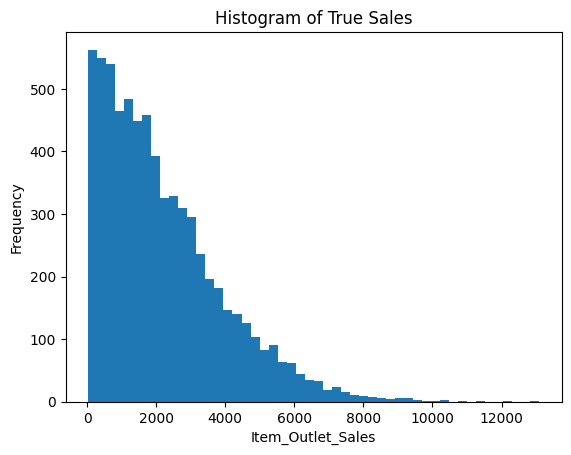

In [62]:


plt.figure()
plt.hist(y_train, bins=50)
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Frequency")
plt.title("Histogram of True Sales")
plt.show()

In [ ]:
# import numpy as np

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)



Final prediction data prep

In [37]:
# Filter df_all_filtered to get the test split data
df_test_final = df_all_filtered[df_all_filtered['split'] == 'test'].copy()

# Prepare features for prediction, similar to how X_train was created
# Drop 'Item_Outlet_Sales' (since it's all 0 for test), 'Item_Identifier', 'Outlet_Identifier', and 'split'
X_final_test = df_test_final.copy()
X_final_test["Outlet_ID_TE"] = X_final_test["Outlet_Identifier"].map(outlet_mean)
X_final_test = X_final_test.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier', 'split'])

# Ensure the columns are in the same order as X_train
X_final_test = X_final_test[X_train.columns] # Use X_train.columns to match order and selected features




# Apply the SAME scaler fitted on X_train to the 'Item_Weight' and 'Item_MRP' of the test data
X_final_test[['Item_Weight']] = scaler.transform(X_final_test[['Item_Weight']])

print(f"Shape of final test features for prediction: {X_final_test.shape}")
display(X_final_test.head())


# '','MRP_x_OutletType,'MRP_squared',,'Item_MRP'

Shape of final test features for prediction: (5681, 15)


,Item_Weight,Visibility_Ratio,Outlet_Age,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_MRP,Outlet_Average_Sales,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC,Outlet_ID_TE
8523,1.688556,1.029192,27,1550,2337.653479,107.8622,2348.354635,0,1,0,0,0,1,0,2382.120509
8524,-0.991712,1.130311,19,1543,2370.972871,87.3198,2340.675263,0,1,0,0,0,1,0,2322.109687
8525,0.364569,1.735215,28,925,371.726653,241.7538,339.351662,1,0,0,0,0,0,1,348.495544
8526,-1.203765,1.291577,19,1543,2370.972871,155.0340,2340.675263,0,1,0,0,0,1,0,2322.109687
8527,0.149286,0.917824,41,1559,3776.820790,234.2300,3694.038558,0,0,0,1,0,1,0,3678.572122


In [38]:
X_final_test.columns

Index(['Item_Weight', 'Visibility_Ratio', 'Outlet_Age', 'Outlet_Item_Count',
       'Item_cat_Avg_Sales_Per_Outlet', 'Item_MRP', 'Outlet_Average_Sales',
       'Outlet_Type_cleaned_grocerystore',
       'Outlet_Type_cleaned_supermarkettype1',
       'Outlet_Type_cleaned_supermarkettype2',
       'Outlet_Type_cleaned_supermarkettype3', 'item_category_DR',
       'item_category_FD', 'item_category_NC', 'Outlet_ID_TE'],
      dtype='object')

Experiment 1: Ensemble Rf model and Light GBM

In [ ]:
# threshold = y_train.quantile(0.75)

# weights = np.where(y_train > threshold, 2, 1)

# weights = 1 + (y_train / y_train.mean())


In [ ]:
# residuals = np.abs(y_train - rf_model.predict(X_train))

# weights = 1 + (residuals / residuals.mean())

# weights = weights / np.mean(weights)

In [39]:


# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(
    n_estimators=177,
    max_depth=6,
    min_samples_leaf=7,
    max_features= 0.7785524356036123,
    random_state=71
)

# Train the model
rf_model.fit(X_train, y_train)
# rf_model.fit(X_train, y_train, sample_weight=weights)
# rf_model.fit(X_train, y_train_capped)

print("Random Forest model training complete on scaled data.")






    # n_estimators=100,             # Number of trees in the forest
    # random_state=42,              # Random seed for reproducibility
    # max_depth=10,                 # Maximum depth of the tree
    # min_samples_leaf=5            # Minimum number of samples required to be at a leaf node

Random Forest model training complete on scaled data.


# For Light GBMmodel I tried with different objectives like 'quantile', 'tweedie', 'regression' but nothing was better than Randomforest.Even tried putting weights for high sales buckets, but that also did not perform well

In [40]:



# import lightgbm as lgb

# model = lgb.LGBMRegressor(
#     objective="quantile",
#     alpha=0.5,   # 0.5 = median
#     n_estimators=2000,
#     learning_rate=0.01,
#     random_state=56
# )

# model = lgb.LGBMRegressor(
#     objective="tweedie",
#     tweedie_variance_power=1.2
# )

# model = lgb.LGBMRegressor(
#     objective="regression",   # default MSE
#     n_estimators=2000,
#     learning_rate=0.01
# )

# # model.fit(X_train, y_train)
# model.fit(X_train, y_train_log)



lgb_model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.01,
    num_leaves=40,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 15
[LightGBM] [Info] Start training from score 2202.365232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, n_estimators=3000,
              num_leaves=40, objective='regression', random_state=42,
              subsample=0.8)

In [ ]:
# rf_model=model

In [41]:
# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)
# y_pred_rf = model.predict(X_test)

# y_pred_log = model.predict(X_test)
# y_pred_rf = np.expm1(y_pred_log)

# Evaluate the model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# rmse_rf = np.sqrt(mean_squared_error(y_test_capped, y_pred_rf))
# r2_rf = r2_score(y_test_capped, y_pred_rf)

print(f"Root Mean Squared Error (RMSE) for Random Forest: {rmse_rf:.2f}")
print(f"R-squared (R2 Score) for Random Forest: {r2_rf:.2f}")

Root Mean Squared Error (RMSE) for Random Forest: 1015.68
R-squared (R2 Score) for Random Forest: 0.62


In [64]:
# # Make predictions on the test set
# y_pred_lgb = lgb_model.predict(X_test)
# # y_pred_rf = model.predict(X_test)

# # y_pred_log = model.predict(X_test)
# # y_pred_rf = np.expm1(y_pred_log)

# # Evaluate the model
# rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
# r2_lgb = r2_score(y_test, y_pred_lgb)

# # rmse_rf = np.sqrt(mean_squared_error(y_test_capped, y_pred_rf))
# # r2_rf = r2_score(y_test_capped, y_pred_rf)

# print(f"Root Mean Squared Error (RMSE) for Random Forest: {rmse_lgb:.2f}")
# print(f"R-squared (R2 Score) for Random Forest: {r2_lgb:.2f}")

In [42]:
# for  ensemble model

pred_lgb = lgb_model.predict(X_test)
pred_rf = rf_model.predict(X_test)
final_pred = 0.2 * pred_lgb + 0.8 * pred_rf

rmse = np.sqrt(mean_squared_error(y_test, final_pred))
print("Ensemble RMSE:", rmse)

Ensemble RMSE: 1018.7882517238553


Experiment 2: Log transformation of dependent

In [43]:
# Initialize a new Random Forest Regressor model for log-transformed target
rf_log_model = RandomForestRegressor(
n_estimators=177,
    max_depth=6,
    min_samples_leaf=7,
    max_features= 0.7785524356036123,
                                      random_state=45
)

# Train the new model using log-transformed target
rf_log_model.fit(X_train, y_train_log)

print("Log-transformed Random Forest model training complete.")

Log-transformed Random Forest model training complete.


In [44]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set using the log-transformed RF model
y_pred_rf_log_new = rf_log_model.predict(X_test)

# Inverse transform predictions and actual values for evaluation
y_pred_rf_new_original = np.expm1(y_pred_rf_log_new)
y_test_original_rf_new = np.expm1(y_test_log)

# Evaluate the new model
rmse_rf_new = np.sqrt(mean_squared_error(y_test_original_rf_new, y_pred_rf_new_original))
r2_rf_new = r2_score(y_test_original_rf_new, y_pred_rf_new_original)

print(f"Root Mean Squared Error (RMSE) for new Log-transformed Random Forest: {rmse_rf_new:.2f}")
print(f"R-squared (R2 Score) for new Log-transformed Random Forest: {r2_rf_new:.2f}")

Root Mean Squared Error (RMSE) for new Log-transformed Random Forest: 1044.50
R-squared (R2 Score) for new Log-transformed Random Forest: 0.60
